In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle, islice
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('results_wup_0.75.csv')

# remove rows where no clusters
df = df.dropna(subset=['machine_clusters'])
df = df.dropna(subset=['human_clusters'])
df['success'] = df['hits'] > 0

# How well overall did machine do

T = 0.8, similarity metric is how similar two word senses are, based on the depth of the two senses in the taxonomy and that of their Least Common Subsumer (most specific ancestor node).

In [2]:
df[['human_assessment_type', 'human_clusters', 'machine_clusters', 'success', 'hits']].head(50)


,human_assessment_type,human_clusters,machine_clusters,success,hits
0,tags,"Imagination,Time,Politics","Time,Materiality,Politics",True,2
1,tags,"Imagination,Land","Land,Imagination,Environmental",True,2
2,tags,"Community,Politics,Economy","Politics,Land,Culture",True,1
3,tags,"Imagination,Time,Mind","Culture,Economy,Time",True,1
4,tags,Immaterial,"Immaterial,Land",True,1
5,tags,"Body,Immaterial","Body,Identity,Immaterial",True,2
6,tags,Immaterial,Immaterial,True,1
7,tags,Materiality,"Materiality,Culture,Land",True,1
8,tags,"Technology,Body,Mind","Politics,Technology,Culture",True,1
9,tags,"Environment,Body","Land,Body,Environmental",True,1


# How well did machine do by human assessment type

In [3]:
df = df[['human_assessment_type', 'human_clusters', 'machine_clusters', 'hits']]
df.groupby('human_assessment_type').agg({'hits':sum}).head()

,hits
human_assessment_type,
description,13
tags,28


In [4]:
df_desc = df.loc[df['human_assessment_type'] == 'description']
df_tags = df.loc[df['human_assessment_type'] == 'tags']

Conclusion from the above is that the machine agrees much more often when the human clustered the works from the tags (vs descriptions).

# human cluster distribution

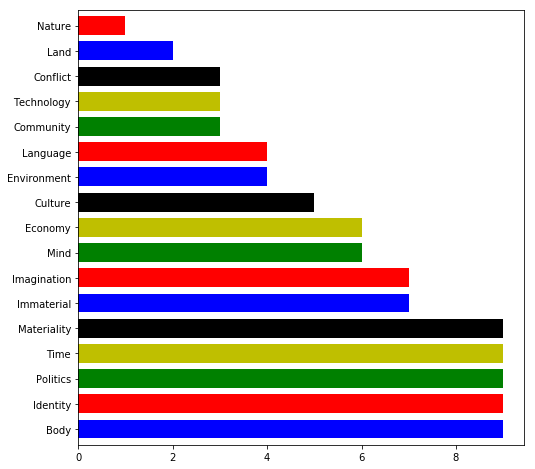

In [5]:
df['human_clusters'].str.split(',', expand=True).head(50)
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
pd.concat([pd.Series(row['human_clusters'].split(','))              
                    for _, row in df.iterrows()]).reset_index()[0]\
    .value_counts().plot(kind='barh', figsize=(8,8), color=my_colors, width=0.75);

# machine cluster distribution

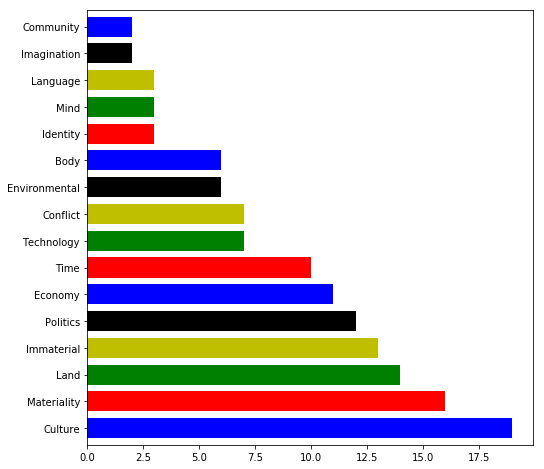

In [6]:
pd.concat([pd.Series(row['machine_clusters'].split(','))              
                    for _, row in df.iterrows()]).reset_index()[0]\
    .value_counts().plot(kind='barh', figsize=(8,8), color=my_colors, width=0.75);

## which clusters did the machine get it rigth for most?

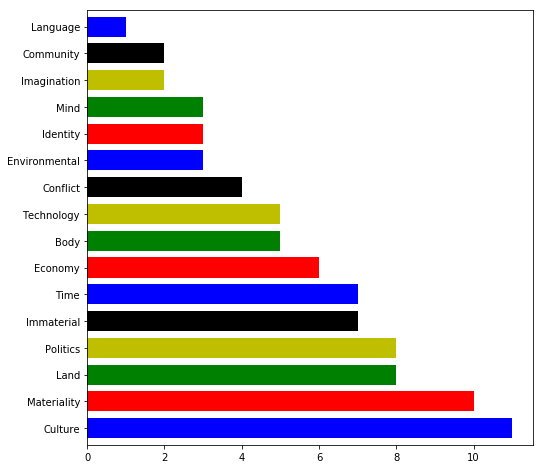

In [7]:
s = df.loc[df['hits'] > 0]['machine_clusters'].str.split(',').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
s.value_counts().plot(kind='barh', figsize=(8,8), color=my_colors, width=0.75);


## and which cluster did the machine get it *wrong* for most?


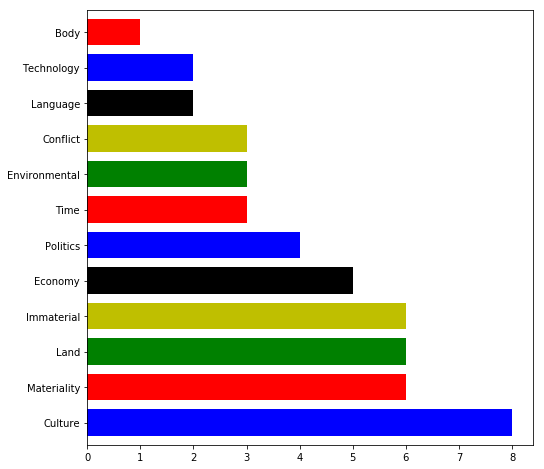

In [8]:
s = df.loc[df['hits']==0]['machine_clusters'].str.split(',').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
s.value_counts().plot(kind='barh', figsize=(8,8), color=my_colors, width=0.75);


# Now calculate the multi-label metric

The Hamming score is closely related to the Hamming loss (the fraction of labels that are incorrectly predicted), but allows for different number of labels (clusters) predicted by man and machine.

In [9]:
from metrics import hamming_score
y_true = list(df['human_clusters'].str.split(','))
y_pred = list(df['machine_clusters'].str.split(','))
print('hamming score (label-based accuracy): {}'.format(hamming_score(y_true, y_pred)))

hamming score (label-based accuracy): 0.624113475177305


# Alternative method for accuracy

If we now consider only the first, most important cluster as predicted by man and machine, the accuracy can be viewed in more familiar terms. (The support is the number of occurrences of each class)

In [10]:
from sklearn.metrics import classification_report

y_true = np.array([x[0] for x in list(df['human_clusters'].str.split(','))])
y_pred = np.array([x[0] for x in list(df['machine_clusters'].str.split(','))])
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        Body       1.00      0.17      0.29         6
   Community       0.00      0.00      0.00         1
    Conflict       0.00      0.00      0.00         2
     Culture       0.00      0.00      0.00         1
     Economy       0.29      0.67      0.40         3
 Environment       0.00      0.00      0.00         2
    Identity       0.00      0.00      0.00         5
 Imagination       0.00      0.00      0.00         3
  Immaterial       1.00      0.67      0.80         3
        Land       0.00      0.00      0.00         0
    Language       0.00      0.00      0.00         3
 Materiality       0.22      0.33      0.27         6
        Mind       0.33      0.50      0.40         2
      Nature       0.00      0.00      0.00         1
    Politics       0.00      0.00      0.00         2
  Technology       0.00      0.00      0.00         3
        Time       0.50      0.25      0.33         4

   micro avg       0.19   